In [1]:
from __future__ import division
import argparse
import matplotlib
matplotlib.use('PS')
%matplotlib inline
import tensorflow as tf
import random 
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '0'

seed = 23
# Setting the seed for numpy-generated random numbers
np.random.seed(seed=seed)

# Setting the seed for python random numbers
random.seed(seed)

# Setting the graph-level random seed.
tf.set_random_seed(seed)

os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.models import Model
from keras.layers import Dense, Activation, Input, concatenate, Lambda, Add
from keras.utils import plot_model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import matplotlib.pyplot as plt 
import GPy
from fipy import *
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 200
import seaborn as sns 
sns.set_context('talk')
sns.set_style('white')
from pdb import set_trace as keyboard
import sys
import time 


/Users/sharmila/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
############################
# Set path to the folder:
folder = r"/Users/sharmila/Desktop/research/work/03_NN_PDE/Level3/part8_image/1_Study_EF_Vs_SR_c=15_f=10_boundedfield/data/"
# loading data
train_data = np.load(os.path.join(folder, 'train_exp_nx=100_lx=0.03_v=1.0_num_samples=10000.npy'))

# bounding input fields from below and above
lower_bound =  np.exp(-5.298317366548036) # 0.005000000000000002
upper_bound =  np.exp(3.5) # 33.11545195869231

train_data = np.where(train_data < lower_bound, lower_bound,train_data) 
train_data  = np.where(train_data > upper_bound, upper_bound, train_data)

input_field_data = train_data 
###########################

In [3]:
print input_field_data.shape

(10000, 100)


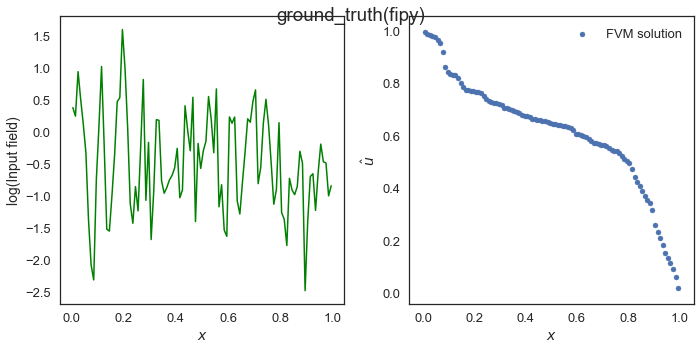

--------------------------------------------------------------


In [4]:
###############################################################
#FIPY solution
value_left = 1
value_right = 0

Lx = 1.  # always put . after 1 
nx = 100
# define mesh
mesh = Grid1D(nx=nx, dx=Lx/nx) # with nx number of cells/cellcenters/pixels/pixelcenters

# define cell and face variables
phi = CellVariable(name='$T(x)$', mesh=mesh, value=0.)
D = CellVariable(name='$D(x)$', mesh=mesh, value=1.0) ## coefficient in diffusion equation
# D = FaceVariable(name='$D(x)$', mesh=mesh, value=1.0) ## coefficient in diffusion equation
source = CellVariable(name='$f(x)$', mesh=mesh, value=1.0)
C = CellVariable(name='$C(x)$', mesh=mesh, value=1.0)

# apply boundary conditions
# dirichet
phi.constrain(value_left, mesh.facesLeft)
phi.constrain(value_right, mesh.facesRight)

# setup the diffusion problem
eq = -DiffusionTerm(coeff=D)+ImplicitSourceTerm(coeff=C) == source

c = 15.
f = 10. #source

source.setValue(f)
C.setValue(c)

# getting input field images
a = input_field_data[ 5 , : ].reshape(-1,1) # just taking one sample
# 'a' is one image of input field: conductivity image of nx cells/cellcenters/pixels/pixelcenters from test_data #returns (nx,1) matrix 
D.setValue(a.ravel())

eq.solve(var=phi)
x_fipy = mesh.cellCenters.value.T ## fipy solution (nx,1) matrix # same as cellcenters defined above
u_fipy = phi.value[:][:, None] ## fipy solution  (nx,1) matrix

# x_face=mesh.faceCenters.value.flatten() #cell faces location i.e.edges of the element 
# y_face=phi.faceValue()                  #cell faces location i.e.edges of the element

# print ('done1')
###############################################################
# Initialize the plot
fig = plt.figure(figsize=(10,5))

try:
    ax1.lines.remove(lines[0])
    ax2.lines.remove(lines[0])
    lines2.set_visible(False)
except:
    pass
##########
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_fipy, np.log(a), 'g', lw=1.5, label='log(Input field)')
ax1.set_xlabel('$x$',  fontsize=14)
ax1.set_ylabel('log(Input field)', fontsize=14)
##########
ax2 = fig.add_subplot(1, 2, 2)
# lines2 = ax2.plot(x_fipy, u_fipy, 'b', lw=2)
# lines2 = plt.scatter(x_fipy, u_fipy, s=10, cmap='Greens', label='FVM solution')
lines2 = ax2.scatter(x_fipy, u_fipy, s=25, cmap='Greens',label='FVM solution')
ax2.set_xlabel('$x$',  fontsize=14)
ax2.set_ylabel(r'$\hat{u}$', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
##########
plt.suptitle('ground_truth(fipy)')
# plt.savefig('ground_truth(fipy)_for_expt_data.png')
plt.show()

print ("--------------------------------------------------------------")
####################################################################################################################


In [6]:
np.save('input_field_ground_truth.npy', (a.T).flatten())
np.save('xfipy_ground_truth.npy', (x_fipy.T).flatten())
np.save('ufipy_ground_truth.npy', (u_fipy.T).flatten())

In [7]:
a = np.load('input_field_ground_truth.npy')
x_fipy = np.load('xfipy_ground_truth.npy')
u_fipy = np.load('ufipy_ground_truth.npy')

In [8]:
print a.shape
print x_fipy.shape
print u_fipy.shape

(100,)
(100,)
(100,)


In [11]:
# https://www.mathworks.com/matlabcentral/answers/115070-adding-noise-with-certain-standard-deviation-to-uncorrupted-data
#assuming noise as Gaussian with mean 0, std 0.1047
# noise = 0.1047*np.randn(1000,1);

std_dev = 0.03
noise = std_dev * np.random.randn(*u_fipy.shape)
#or
# noise = np.random.normal(0, std_dev, u_fipy.shape)

u_sensor = u_fipy + noise 
print u_sensor

[1.01665719 0.99063377 0.96193869 1.00977752 0.9967327  0.93616409
 0.94247926 0.88499612 0.82467297 0.89702066 0.82627309 0.85403733
 0.84076792 0.82358127 0.76910714 0.75502232 0.79064979 0.8077229
 0.71635142 0.74220147 0.76336603 0.79895011 0.7790215  0.77609703
 0.7498874  0.70596455 0.7252762  0.76560805 0.73079021 0.68463428
 0.75905361 0.72216237 0.72741333 0.76272434 0.68458929 0.67557567
 0.61552266 0.69046765 0.70006684 0.67744345 0.67553489 0.69968927
 0.67901964 0.67667017 0.66060945 0.65913227 0.69009529 0.6539962
 0.64044401 0.63358467 0.64334425 0.65006683 0.65808418 0.64520239
 0.62904493 0.58834116 0.65386152 0.59925661 0.61686366 0.64550558
 0.61375974 0.57963595 0.62288004 0.59019097 0.57426343 0.61777706
 0.59539112 0.66732123 0.53638515 0.5665077  0.57721128 0.60061597
 0.54528089 0.59568973 0.54988125 0.52017278 0.53193775 0.52481327
 0.50808093 0.48724559 0.4909199  0.50467817 0.47279835 0.48318282
 0.38580246 0.36063373 0.43630158 0.37056565 0.35831946 0.294467

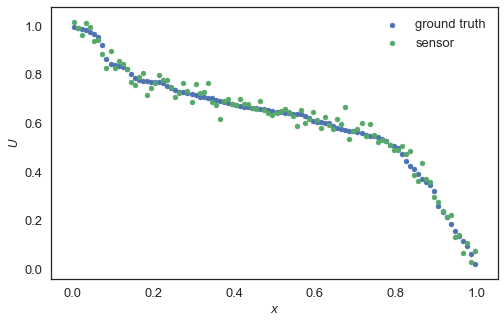

In [12]:
# Initialize the plot
fig = plt.figure(figsize=(8,5))
##########
ax3 = fig.add_subplot(1, 1, 1)
lines2 = ax3.scatter(x_fipy[:,None], u_fipy[:,None],s=25, cmap='Greens',label='ground truth')
lines3 = ax3.scatter(x_fipy[:,None], u_sensor[:,None],s=25,cmap='Greens',label='sensor')
ax3.set_xlabel('$x$',  fontsize=12)
ax3.set_ylabel(r'$U$',  fontsize=12)
plt.legend(loc='best')
plt.show()
##########

In [13]:
print (x_fipy[20],x_fipy[30],x_fipy[40],x_fipy[50],x_fipy[60],x_fipy[70],x_fipy[80])

(0.20500000000000002, 0.305, 0.405, 0.505, 0.605, 0.705, 0.805)


In [14]:
print (u_sensor[20],u_sensor[30],u_sensor[40],u_sensor[50],u_sensor[60],u_sensor[70],u_sensor[80])

(0.7633660270634811, 0.7590536094026412, 0.6755348939987039, 0.6433442468899135, 0.6137597421640841, 0.5772112819430778, 0.4909199041904633)
